# *Importing Libraries*

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import time
import copy
import timm

import torch
import torch.nn as nn
from torchvision.transforms import v2
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, Adamax, lr_scheduler
from torch.optim.lr_scheduler import ExponentialLR

from tqdm.notebook import tqdm

from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, auc
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# *Data*
## *Create DataFrame*

In [3]:
dataset_path = '/kaggle/input/nose-dataset/Dataset'

paths = []
labels = []

for category in ['normal', 'fracture']:
    category_path = os.path.join(dataset_path, category)
    
    for folder_name in os.listdir(category_path):
        folder_path = os.path.join(category_path, folder_name)
        
        if os.path.isdir(folder_path):
            for image_name in ['R', 'L']:
                image_path = os.path.join(folder_path, f'{image_name}.jpg')
                
                if os.path.exists(image_path):
                    paths.append(image_path)
                    labels.append(category)

                    
df = pd.DataFrame({'image_path': paths, 'label': labels})
df.head()

,image_path,label
0,/kaggle/input/nose-dataset/Dataset/normal/1402...,normal
1,/kaggle/input/nose-dataset/Dataset/normal/1402...,normal
2,/kaggle/input/nose-dataset/Dataset/normal/1402...,normal
3,/kaggle/input/nose-dataset/Dataset/normal/1402...,normal
4,/kaggle/input/nose-dataset/Dataset/normal/1401...,normal


In [4]:
df.shape

(2968, 2)

In [5]:
def read_images_from_df(df):
    images = []
    labels = []
    for index, row in df.iterrows():
        img_path = row['image_path']
        if row['label'] == "normal":
            label = 0
        else: label = 1
        img = cv2.imread(img_path)
        img = img[:img.shape[1], :]
        if img is not None:
            images.append(img)
            labels.append(label)
    return images, labels

images, labels = read_images_from_df(df)

# *Preprocessing*

In [6]:
def sharpen_image(image, kernel_size=(3, 3), strength=0.25):
    kernel = np.array([[0, -1, 0],
                       [-1, 4, -1],
                       [0, -1, 0]])

    sharpened = cv2.filter2D(image, -1, kernel)

    sharpened = cv2.addWeighted(image, 1 + strength, sharpened, -strength, 0)

    return sharpened

In [7]:
def preprocessing(img):
    img = img[:img.shape[1], :]
    
    img = cv2.resize(img, (224,224), interpolation=cv2.INTER_AREA)
    
    gray_image = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(16,16))
    cl1 = clahe.apply(gray_image)
    
    sharp1 = sharpen_image(cl1)
    
    cl2 = 1 - sharp1
    
    sharp2 = sharpen_image(cl2)
    
    rgb = cv2.cvtColor(sharp2, cv2.COLOR_GRAY2RGB)

    rgb = 1 - rgb
    
    return rgb

In [8]:
preprocessed_images = copy.deepcopy(images)
for i in range (len(images)):
    preprocessed_images[i] = preprocessing(images[i])

### show sample

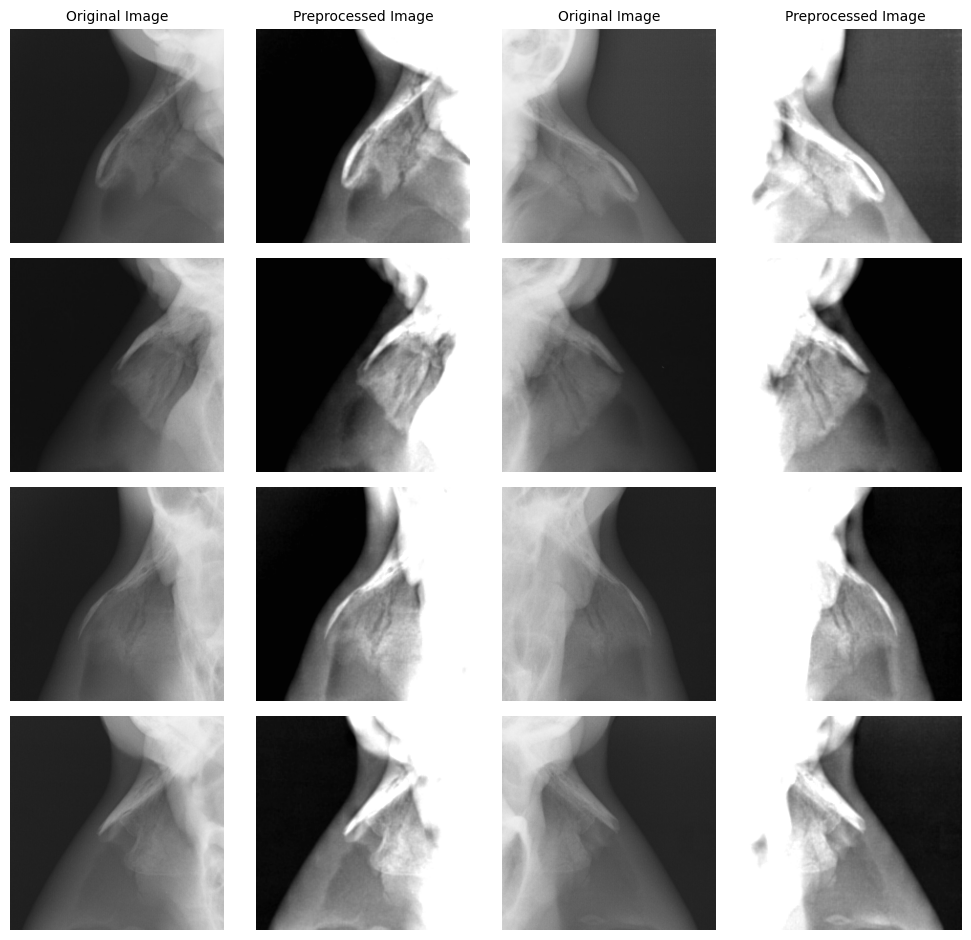

In [9]:
def show_smp(images, preprocessed_images, labels):
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))

    for col in range(4):
        if col % 2 == 0:
            axes[0, col].set_title('Original Image', fontsize=10)
        else:
            axes[0, col].set_title('Preprocessed Image', fontsize=10)

    for i in range(8):
        ax = axes[i // 2, (i % 2) * 2]
        ax.imshow(images[i])
        ax.axis('off')

        ax = axes[i // 2, (i % 2) * 2 + 1]
        ax.imshow(preprocessed_images[i])
        ax.axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
    

show_smp(images, preprocessed_images, labels)

## *Split data on train val test*

In [10]:
X_train, X_val_test, y_train, y_val_test = train_test_split(np.asarray(preprocessed_images), np.asarray(labels), 
                                                            test_size=0.3, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.66, random_state=42)

In [11]:
print("shape of X_train is: {} ".format(X_train.shape))
print("shape of X_val is: {}".format(X_val.shape))
print("shape of X_test is: {}".format(X_test.shape))
print()
print("shape of y_train is: {} ".format(y_train.shape))
print("shape of y_val is: {}".format(y_val.shape))
print("shape of y_test is: {}".format(y_test.shape))

shape of X_train is: (2077, 224, 224, 3) 
shape of X_val is: (302, 224, 224, 3)
shape of X_test is: (589, 224, 224, 3)

shape of y_train is: (2077,) 
shape of y_val is: (302,)
shape of y_test is: (589,)


## *Augmentation, Dateset and DataLoader*

In [12]:
train_transform = v2.Compose([
    v2.RandomRotation(10),
    v2.ColorJitter(brightness=0.3, contrast=0.3, saturation=0, hue=0),
    v2.RandomHorizontalFlip(),
    v2.RandomAffine(degrees=0, translate=(0.2, 0.2), shear=0.2),
    v2.ToImage(), v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_test_transform = v2.Compose([
    v2.ToImage(), v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [13]:
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        try:
            image = self.images[idx]
            label = self.labels[idx]
            if self.transform:
                image = Image.fromarray(image.astype('uint8'), 'RGB') 
                image = self.transform(image)
            return image, label
        except Exception as e:
            print(f"Error processing index {idx}: {e}")
            raise

In [14]:
# Create datasets
train_dataset = CustomDataset(X_train, y_train, transform=train_transform)
val_dataset = CustomDataset(X_val, y_val, transform=val_test_transform)
test_dataset = CustomDataset(X_test, y_test, transform=val_test_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

### show sample

images shape:  torch.Size([32, 3, 224, 224])
labels shape:  torch.Size([32])


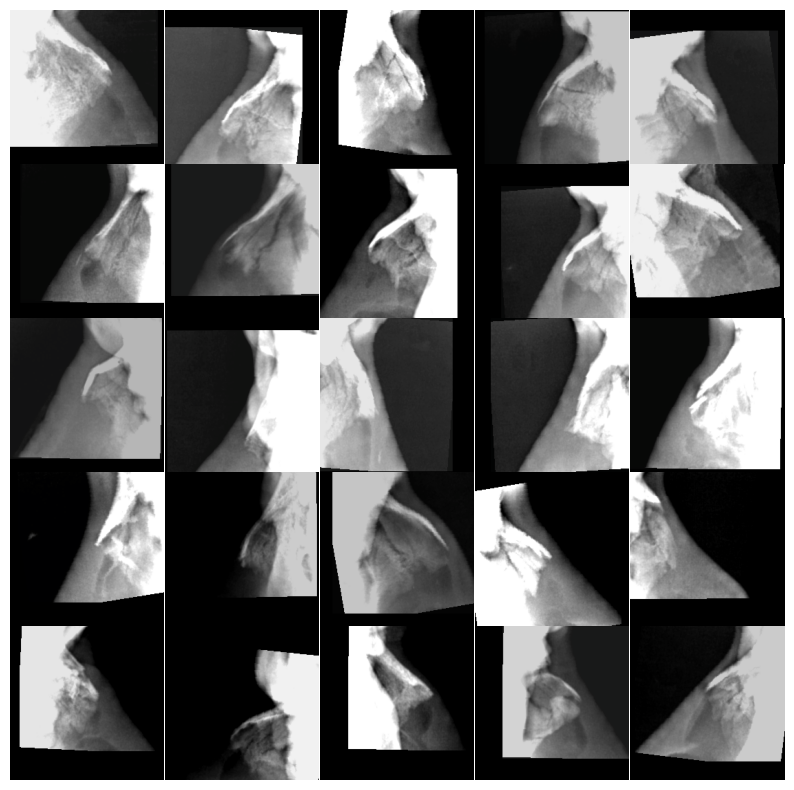

In [15]:
def show_aug(inputs, nrows=5, ncols=5, image=True):
    plt.figure(figsize=(10, 10))
    plt.subplots_adjust(wspace=0., hspace=0.)
    i_ = 0
    
    if len(inputs) > 25:
        inputs = inputs[:25]
        
    for idx in range(len(inputs)):
    
        img = inputs[idx].numpy().transpose(1,2,0)
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225] 
        img = (img*std+mean).astype(np.float32)
        img = np.clip(img, 0, 1)

        plt.subplot(nrows, ncols, i_+1)
        plt.imshow(img); 
        plt.axis('off')
 
        i_ += 1
        
    return plt.show()

    
images, labels= next(iter(train_loader))
print('images shape: ', images.shape)
print('labels shape: ', labels.shape)

show_aug(images)

## *Train Model*

In [16]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 80)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() 
            else:
                model.eval()  

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.cpu().numpy())
                
                print('{}: \t *** \t Loss: {:.4f} \t *** \t Acc: {:.4f} \t *** \t lr: {:.4f}'.format(
                    phase, epoch_loss, epoch_acc, optimizer.param_groups[0]['lr']))
                
#                 scheduler.step()
                
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.cpu().numpy())
                
                print('{}: \t *** \t Loss: {:.4f} \t *** \t Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

                
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    
    print()

    model.load_state_dict(best_model_wts)
    return model, history

dataloaders = {
    'train': train_loader,
    'val': val_loader
}

In [17]:
def draw_plot(history):
    acc = history['train_acc']
    val_acc = history['val_acc']
    loss = history['train_loss']
    val_loss = history['val_loss']
    
    fig, axis = plt.subplots(1, 2, figsize=(15,6))
    axis[0].set_title('Training & validation accuracy', fontsize = 15, fontweight = 'bold')
    axis[0].plot(acc, label='training accuracy', color='darkblue')
    axis[0].plot(val_acc, label='validation accuracy', color='deeppink')
    axis[0].legend()
    axis[1].set_title('Training & validation loss', fontsize = 15, fontweight = 'bold')
    axis[1].plot(loss, label='training loss', color='darkblue')
    axis[1].plot(val_loss, label='validation loss', color='deeppink')
    axis[1].legend()
    
    print("Maximum Accuracy of Training set: {:.3f}\nMinimum Loss of Trainig set: {:.8f}\n".format(np.max(acc)*100, np.min(loss)))
    print("Maximum Accuracy of Validation set: {:.3f}\nMinimum Loss of Validation set: {:.8f}\n".format(np.max(val_acc)*100, np.min(val_loss))) 

---
# *Model Structure*

## ConViT (Convolutional Vision Transformer):

In [43]:
x = 0
# timm.list_models(pretrained=True)[x:x + 700]

---
vit_base_patch32_224.augreg_in21k_ft_in1k

vit_small_patch32_224.augreg_in21k_ft_in1k

deit3_base_patch16_224.fb_in22k_ft_in1k

deit3_small_patch16_224.fb_in22k_ft_in1k

swin_base_patch4_window7_224.ms_in22k_ft_in1k

swinv2_cr_small_ns_224.sw_in1k

maxvit_small_tf_224.in1k

cait_s24_224.fb_dist_in1k

cait_xxs36_224.fb_dist_in1k

convit_base.fb_in1k

beit_base_patch16_224.in22k_ft_in22k

fastvit_sa24.apple_dist_in1k

fastvit_t12.apple_dist_in1k

mvitv2_base.fb_in1k

---

In [18]:
num_epochs = 20
num_classes = 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
class Model(nn.Module):
    def __init__(self, url, num_classes):
        super(Model, self).__init__()
        self.model = timm.create_model(url, pretrained=True, num_classes=num_classes)
    
    def forward(self, x):
        return self.model(x)

mvitv2_base.fb_in1k

In [20]:
url = 'mvitv2_base.fb_in1k'
model = Model(url, num_classes).to(device)

model.safetensors:   0%|          | 0.00/206M [00:00<?, ?B/s]

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = Adamax(model.parameters(), lr=0.0001)
scheduler = ExponentialLR(optimizer, gamma=0.98)

Epoch 1/20
--------------------------------------------------------------------------------
train: 	 *** 	 Loss: 0.6248 	 *** 	 Acc: 0.6403 	 *** 	 lr: 0.0001
val: 	 *** 	 Loss: 0.5757 	 *** 	 Acc: 0.7086

Epoch 2/20
--------------------------------------------------------------------------------
train: 	 *** 	 Loss: 0.5084 	 *** 	 Acc: 0.7472 	 *** 	 lr: 0.0001
val: 	 *** 	 Loss: 0.5087 	 *** 	 Acc: 0.7384

Epoch 3/20
--------------------------------------------------------------------------------
train: 	 *** 	 Loss: 0.4311 	 *** 	 Acc: 0.8002 	 *** 	 lr: 0.0001
val: 	 *** 	 Loss: 0.4833 	 *** 	 Acc: 0.7781

Epoch 4/20
--------------------------------------------------------------------------------
train: 	 *** 	 Loss: 0.4011 	 *** 	 Acc: 0.8156 	 *** 	 lr: 0.0001
val: 	 *** 	 Loss: 0.4468 	 *** 	 Acc: 0.8013

Epoch 5/20
--------------------------------------------------------------------------------
train: 	 *** 	 Loss: 0.3563 	 *** 	 Acc: 0.8450 	 *** 	 lr: 0.0001
val: 	 *** 	 Loss

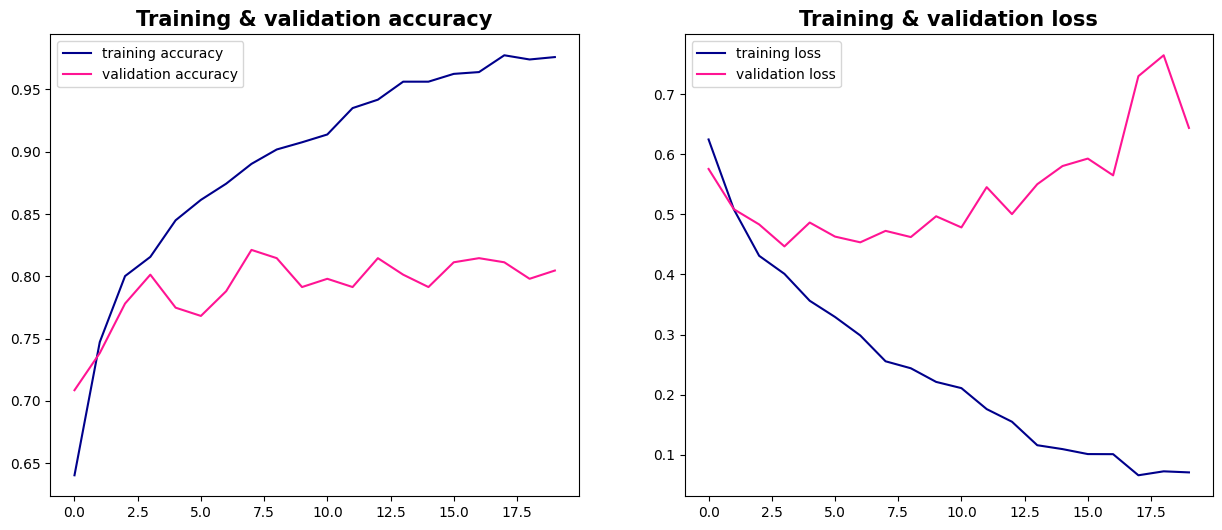

In [22]:
model, history = train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs)
draw_plot(history)

## *Evaluation:*

In [23]:
model.eval() 

running_corrects = 0

y_pred = []
y_test = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        running_corrects += torch.sum(preds == labels.data)

        y_pred.extend(preds.cpu().numpy())
        y_test.extend(labels.cpu().numpy())

y_pred = np.asarray(y_pred)
y_test = np.asarray(y_test)

test_acc = running_corrects.double() / len(test_loader.dataset)
print('Test Acc: {:.4f}'.format(test_acc))

Test Acc: 0.8421


## *Calculate classification report:*

In [24]:
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
print(f'Precision: {precision:.6f}')
print(f'Recall: {recall:.6f}')

Precision: 0.842121
Recall: 0.842105


In [25]:
report = classification_report(y_test, y_pred, target_names=['normal', 'fracture'])
print(report)

              precision    recall  f1-score   support

      normal       0.85      0.84      0.85       301
    fracture       0.84      0.84      0.84       288

    accuracy                           0.84       589
   macro avg       0.84      0.84      0.84       589
weighted avg       0.84      0.84      0.84       589



## *Compute confusion matrix:*

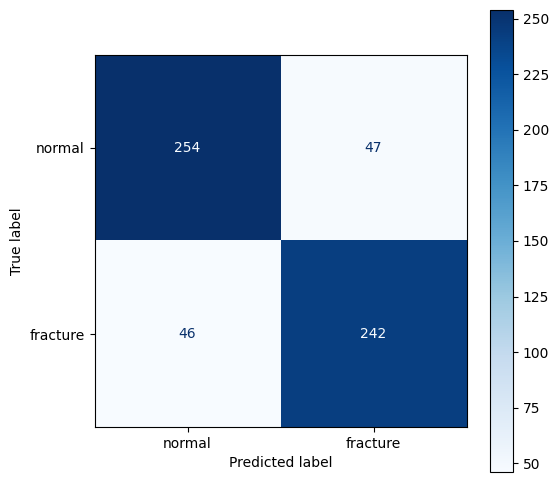

In [26]:
cm = confusion_matrix(y_test, y_pred)

class_labels = ['normal', 'fracture']

display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

fig, ax = plt.subplots(figsize=(6, 6))
display.plot(ax=ax, values_format='.4g', cmap='Blues')
plt.show()

In [27]:
auc_metric = roc_auc_score(y_test, y_pred)
print("AUC:", auc_metric)

AUC: 0.8420657991878922


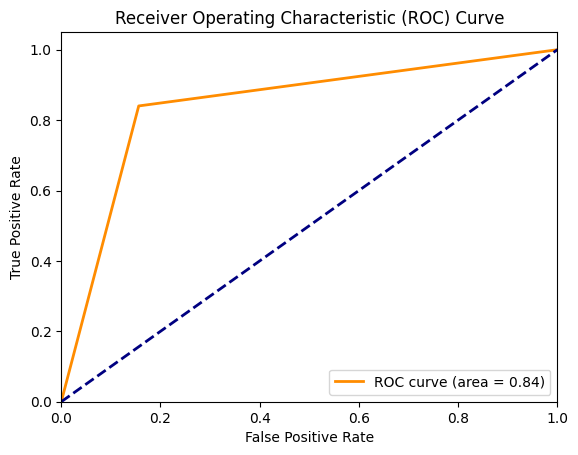

In [28]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [31]:
# Save the entire model
# torch.save(model, 'best_model_entire.pth')

fastvit_t12.apple_dist_in1k

In [38]:
url = 'fastvit_t12.apple_dist_in1k'
model = Model(url, num_classes).to(device)

In [39]:
criterion = nn.CrossEntropyLoss()
optimizer = Adamax(model.parameters(), lr=0.0001)
scheduler = ExponentialLR(optimizer, gamma=0.98)

Epoch 1/50
--------------------------------------------------------------------------------
train: 	 *** 	 Loss: 0.6949 	 *** 	 Acc: 0.5383 	 *** 	 lr: 0.0001
val: 	 *** 	 Loss: 0.6868 	 *** 	 Acc: 0.5364

Epoch 2/50
--------------------------------------------------------------------------------
train: 	 *** 	 Loss: 0.6762 	 *** 	 Acc: 0.5676 	 *** 	 lr: 0.0001
val: 	 *** 	 Loss: 0.6752 	 *** 	 Acc: 0.5695

Epoch 3/50
--------------------------------------------------------------------------------
train: 	 *** 	 Loss: 0.6578 	 *** 	 Acc: 0.6105 	 *** 	 lr: 0.0001
val: 	 *** 	 Loss: 0.6668 	 *** 	 Acc: 0.5861

Epoch 4/50
--------------------------------------------------------------------------------
train: 	 *** 	 Loss: 0.6439 	 *** 	 Acc: 0.6259 	 *** 	 lr: 0.0001
val: 	 *** 	 Loss: 0.6587 	 *** 	 Acc: 0.6126

Epoch 5/50
--------------------------------------------------------------------------------
train: 	 *** 	 Loss: 0.6229 	 *** 	 Acc: 0.6529 	 *** 	 lr: 0.0001
val: 	 *** 	 Loss

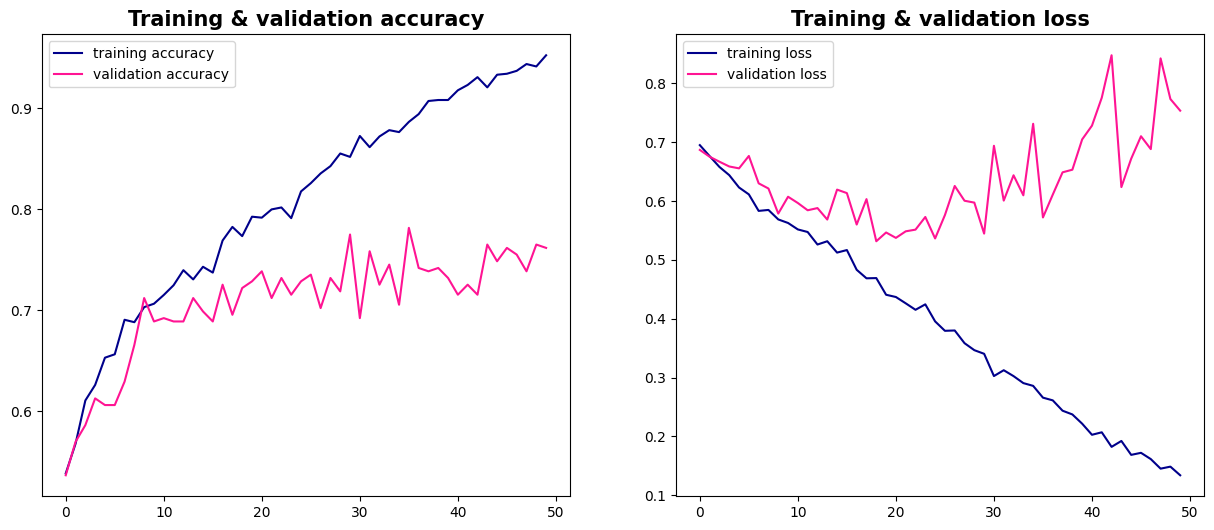

In [40]:
model, history = train_model(model, dataloaders, criterion, optimizer, scheduler, 50)
draw_plot(history)

## *Evaluation:*

In [41]:
model.eval() 

running_corrects = 0

y_pred = []
y_test = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        running_corrects += torch.sum(preds == labels.data)

        y_pred.extend(preds.cpu().numpy())
        y_test.extend(labels.cpu().numpy())

y_pred = np.asarray(y_pred)
y_test = np.asarray(y_test)

test_acc = running_corrects.double() / len(test_loader.dataset)
print('Test Acc: {:.4f}'.format(test_acc))

Test Acc: 0.8031


## *Calculate classification report:*

In [42]:
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
print(f'Precision: {precision:.6f}')
print(f'Recall: {recall:.6f}')

Precision: 0.808754
Recall: 0.803056


In [43]:
report = classification_report(y_test, y_pred, target_names=['normal', 'fracture'])
print(report)

              precision    recall  f1-score   support

      normal       0.77      0.88      0.82       301
    fracture       0.85      0.73      0.78       288

    accuracy                           0.80       589
   macro avg       0.81      0.80      0.80       589
weighted avg       0.81      0.80      0.80       589



## *Compute confusion matrix:*

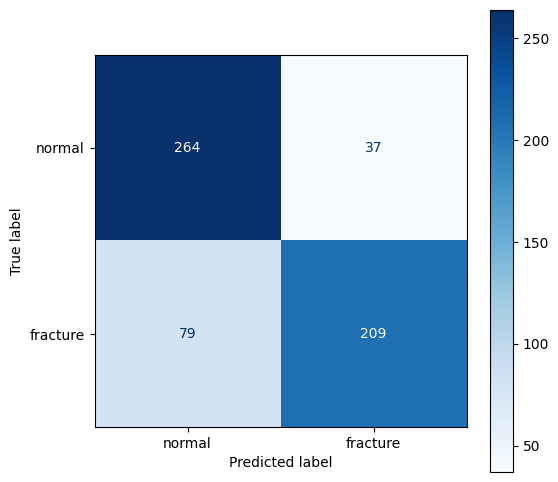

In [44]:
cm = confusion_matrix(y_test, y_pred)

class_labels = ['normal', 'fracture']

display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

fig, ax = plt.subplots(figsize=(6, 6))
display.plot(ax=ax, values_format='.4g', cmap='Blues')
plt.show()

In [45]:
auc_metric = roc_auc_score(y_test, y_pred)
print("AUC:", auc_metric)

AUC: 0.8013854282022886


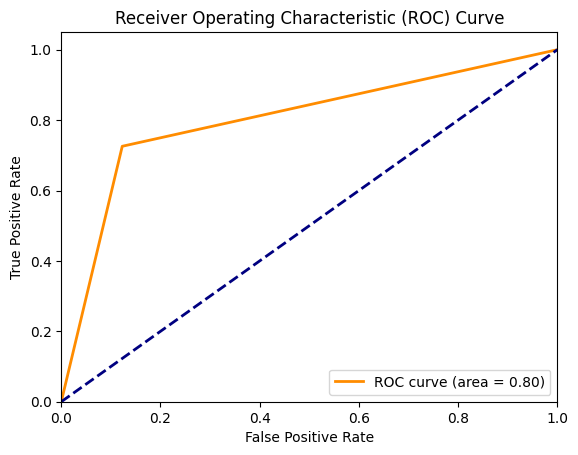

In [46]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [47]:
# Save the entire model
# torch.save(model, 'best_model_entire.pth')